In [268]:
from IPython.core.display import HTML
import os

import os
# import re
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

from IPython.display import Image
from urllib import urlretrieve

HTML(os.path.join(os.pardir, r'golems\css_theme.txt'))

Populating the interactive namespace from numpy and matplotlib


### Time Period and Stock for Testing
We will use IBM and trade it from December 31, 2007 until December 31, 2009.

<a id='Bollinger Band Strategy Chart'></a>
### Part 1A: Bollinger Band Strategy Chart (15%)
If you don't know about Bollinger Bands already, go learn about them. Here are some references:
[stockcharts](http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:bollinger_bands)
[wikipedia](https://en.wikipedia.org/wiki/Bollinger_Bands)

Here are the essential things you need to know and to implement. In addition to the price of a stock over time, Bollinger Bands include:
* 20 day simple moving average (SMA) line.
* Upper Band = SMA + 2 * 20 day standard deviation.
* Lower Band = SMA - 2 * 20 day standard deviation.

A basic Bollinger Band trading strategy works as follows: There are two potential entries, long and short. 
* **The long entry is made when the price transitions from below the lower band to above the lower band.** This indicates that the stock price has moved substantially away from the moving average, but is now moving back towards the moving average. When this entry signal criteria is met, buy the stock and hold it until the exit. **The exit signal occurs when the price moves from below the SMA to above it.**

* The short entry and exit are mirrors of the long entry and exit: **The short entry is made when the price transitions from above the upper band to below the upper band**. This indicates that the stock price has moved substantially away from the moving average, but is now moving back towards the moving average. When this entry signal criteria is met, short the stock and hold it until the exit. **The exit signal occurs when the price moves from above the SMA to below it.**

You should create a chart that shows:
* Stock price (adjusted close)
* SMA
* Upper Band
* Lower Band
* Long entries as a vertical green line at the time of entry.
* Long exits as a vertical black line at the time of exit.
* Short entries as a vertical RED line at the time of entry.
* Short exits as a vertical black line at the time of exit.

### Part 1B: Bollinger Band Strategy Backtest (15%)
Reuse your charting code to generate trades. Start with $10,000. For a long entry, BUY 100 shares and hold until the exit. For a short entry, SELL 100 shares and hold until the exit. Chart the performance of your fund over the time period described in "what to turn in" below.

# Convenience Functions

In [271]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import sys
sys.path.append(r'..\mc2_p1')
from marketsim import *


In [272]:
def symbol_to_path(symbol, base_dir="..\data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

In [273]:
print symbol_to_path('IBM')

..\data\IBM.csv


In [274]:
def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])
    return df

def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

# Solution <a id='Solution'></a>

In [275]:
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return pd.rolling_mean(values, window=window)


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    # TODO: Compute and return rolling standard deviation
    return pd.rolling_std(values, window = window)


def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    # TODO: Compute upper_band and lower_band
    upper_band = rm + (2 * rstd)
    lower_band = rm - (2 * rstd)
    return upper_band, lower_band


def create_orders_file(trades, symbol, path = '..\mc2_p1\orders\orders_BB.csv'):
    ''' takes trades dataframe and creates a orders_BB.csv file that can be backtested.
        orders file is deposited in the backtesting folder at ..\mc2_p1\orders\orders_BB.csv
    
    sample input: trades df, symbol = 'IBM'
    ------------
                index   trade
        0  2008-02-28   -100
        1  2008-03-27    100
        2  2008-04-22   -100
        3  2008-05-21    100

    sample output: creates csv file with the following format
    -------------
        Date,Symbol,Order,Shares
        2008-02-28,IBM,SELL,100
        2008-03-27,IBM,BUY,100
        2008-04-22,IBM,SELL,100
        2008-05-21,IBM,BUY,100
    '''
    headers = ['Date', 'Symbol', 'Order', 'Shares']
    orders = []
    
    trades = trades.reset_index()
    trades['Date'] = trades['index'].apply(lambda x: str(x)[:10])
    trades['Symbol'] = symbol
    trades['Order'] = np.where(trades['trade'] > 0, 'BUY', 'SELL')
    trades['Shares'] = trades['trade'].abs()
    
    for i in trades.index: orders.append(trades.ix[i, 'Date':'Shares'])
        
    with open(path,'wb') as f:
        f_csv = csv.writer(f)
        f_csv.writerow(headers)
        f_csv.writerows(orders)
        
    return trades.ix[:,'Date':'Shares']


def plt_bollinger(symbol, df):
    '''plots stock rice, bollinger bands, rolling mean price as well as buy, sell and exit dates.'''
    
    # calculate long, short, and exit dates for vertical lines
    def vline_dates(s): return s[s == True].index
    df['exit_vline'] = (df['trade'] != 0) & (df['position'] == 0) 
    df['long_vline'] = (df['trade'] > 0) & (df['position'] != 0) 
    df['short_vline'] = (df['trade'] < 0) & (df['position'] != 0) 
    exit_dates = vline_dates(df['exit_vline'])
    long_dates = vline_dates(df['long_vline'])
    short_dates = vline_dates(df['short_vline'])
    
    # plot price of stock
    ax = df[symbol].plot(title="Bollinger Band Strategy", label = str(symbol) + " Adj Close")
    
    # plot rolling mean and bollinger bands
    df['rm'].plot(label='20d moving average', ax=ax, style='y')
    df['upper_band'].plot(label='Bollinger Bands', ax=ax, style='c')
    df['lower_band'].plot(label='', ax=ax, style='c')
    ymin, ymax = ax.get_ylim()
    
    # plot vertical lines
    ax.vlines(x = long_dates, ymin=ymin, ymax=ymax, color = 'green', label='long trade')
    ax.vlines(x = short_dates, ymin=ymin, ymax=ymax, color = 'red', label='short trade')
    ax.vlines(x = exit_dates, ymin=ymin, ymax=ymax, color = 'black', linestyles = 'dashed', label='exit')
    
    # Add axis labels and legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='lower left')
    plt.show()


def create_bollinger_strat(symbol, dates):  
    ''' generates trades using a basic Bollinger Band strategy. 
        In this strategy there are two potential entries, long and short. 
       
        - The long entry is made when the price transitions from below the lower 
          band to above the lower band. This indicates that the stock price has 
          moved substantially away from the moving average (SMA), but is now moving 
          back towards the moving average. When this entry signal criteria is met, 
          buy the stock and hold it until the exit. The exit signal occurs when 
          the price moves from below the SMA to above it.
         
        - The short entry and exit are mirrors of the long entry and exit: The 
          short entry is made when the price transitions from above the upper 
          band to below the upper band. This indicates that the stock price 
          has moved substantially away from the moving average, but is now 
          moving back towards the moving average. When this entry signal 
          criteria is met, short the stock and hold it until the exit. 
          The exit signal occurs when the price moves from above the SMA to below it.
    
    sample input: stock symbol and date range
    ------------
    
    sample output: 
    -------------
                 Date Symbol Order  Shares
        0  2008-02-28    IBM  SELL     100
        1  2008-03-27    IBM   BUY     100
        2  2008-04-22    IBM  SELL     100
        3  2008-05-21    IBM   BUY     100
        4  2008-07-01    IBM   BUY     100
    '''
    
    # create pricing dataframe for symbol
    price_all = get_data(symbol, dates) 
    # adds SPY to the 0 position of symbol list (benchmark reference) and gets prices of symbols
    price_df = price_all[symbol[1]] # pandas timeseries of stock price
    
    # calc Bollinger lines
    rm = get_rolling_mean(price_df, window=20)              # 1. rolling mean
    rstd = get_rolling_std(price_df, window=20)             # 2. rolling standard deviation
    upper_band, lower_band = get_bollinger_bands(rm, rstd)  # 3. upper and lower bands
    
    # calc helper columns to leverage power of pandas vectorized operations
    df = pd.DataFrame(price_df)  # dataframe to calc helper columns, start with stock price data
    
    df['rm'] = rm
    df['upper_band'] = upper_band
    df['lower_band'] = lower_band
    df['above_upper'] = df[price_df.name] > df['upper_band']  # stock price > rm + (2 * rstd)
    df['below_lower'] = df[price_df.name] < df['lower_band']  # stock price < rm - (2 * rstd)
    df['trade'] = 0
    df['position'] = np.NaN  # share position in symbol
    df.ix[0,'position'] = 0  # starting share position = 0
    df['long_sig'] = df['below_lower'] < df['below_lower'].shift()   
    # long signal: stk price transitions from below the lower band to above the lower band
    df['short_sig'] = df['above_upper'] < df['above_upper'].shift()
    # short signal: stk price transitions from above the upper band to below the upper band
    
    # generate trades for bollinger investment strategy
    int_index = df.reset_index().index[1:] 
    for row in int_index:
        df.ix[row, 'position'] = df.ix[row - 1, 'position']  # carry forward last shr position 
        
        # buy 100 shares if any of 2 conditions is true
        # 1) share position = 0 and long_sig == True; or, 
        # 2) share position = short (negative) and stock price moves from above 20d rolling mean to below it
        if (df.ix[row, 'position'] == 0 and df.ix[row, 'long_sig'] == True) or \
           (df.ix[row, 'position'] < 0 and df.ix[row, 0] < df.ix[row, 'rm']):
            df.ix[row, 'trade'] = 100
            
        # sell 100 shares if any of 2 conditions is true
        # 1) share position = 0 and short_sig == True; or, 
        # 2) share position = long (positive) and stock price moved from below 20d rolling mean to above it
        elif (df.ix[row, 'position'] == 0 and df.ix[row, 'short_sig'] == True) or \
             (df.ix[row, 'position'] > 0 and df.ix[row, 0] > df.ix[row, 'rm']):
            df.ix[row, 'trade'] = -100
            
        else: df.ix[row, 'trade'] = 0
        df.ix[row, 'position'] = df.ix[row, 'position'] + df.ix[row, 'trade']  
        # update shr position for most recent trade
        
    trades = df[df.ix[:,'trade'] != 0]  # drop days where no trades occured
    trades = trades['trade']            # dumps helper columns

    # create orders csv file
    trades = create_orders_file(trades, 'IBM')  # create CSV file to feed to market simulator (backtesting)
    # new orders file is put in backtest directory  ..\mc2_p1\orders\orders_BB.csv
    
    # plot strategy

    plt_bollinger(symbol[1], df)
    return trades 
    

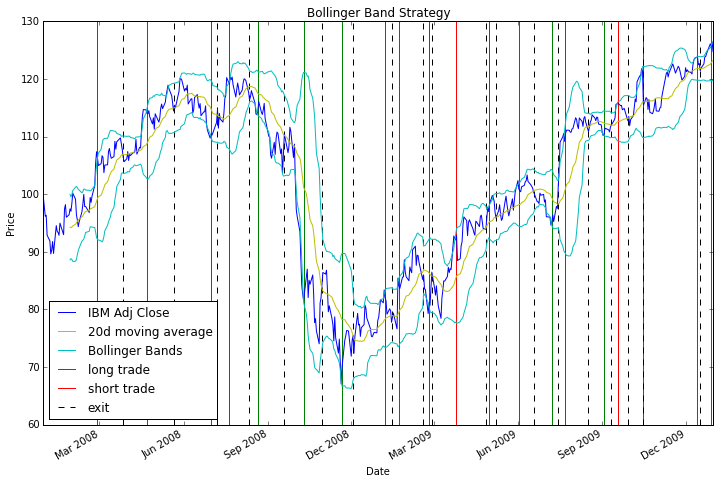

Backtest Results
----------------
Data Range: 2007-12-31 to 2009-12-31

Sharpe Ratio of Fund: 0.97745615082
Sharpe Ratio of $SPX: -0.21996865409

Cumulative Return of Fund: 0.3614
Cumulative Return of $SPX: -0.240581328829

Standard Deviation of Fund: 0.0108802922269
Standard Deviation of $SPX: 0.0219524869863

Average Daily Return of Fund: 0.000669942567631
Average Daily Return of $SPX: -0.000304189525556

Final Portfolio Value: 13614.0


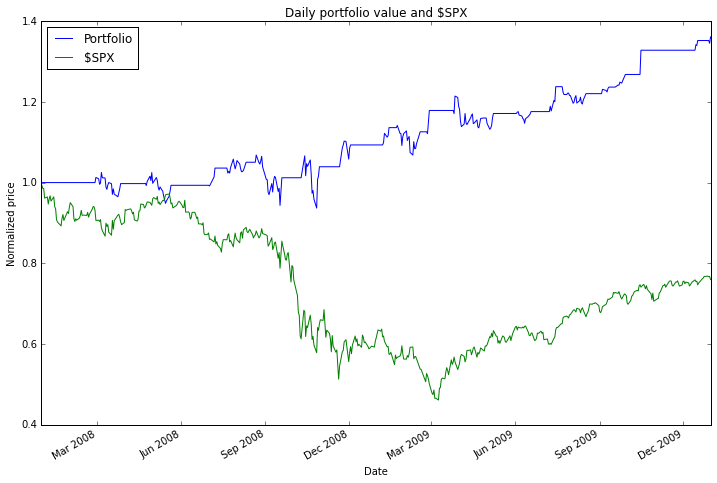

In [276]:
def test_run():
    
    symbol = ['IBM']; 
    start_date = '2007-12-31'
    end_date = '2009-12-31'
    dates = pd.date_range(start_date, end_date)
    # symbol = ['IBM']; dates = pd.date_range('2008-12-04','2009-02-03') # test short signals
    # symbol = ['IBM']; dates = pd.date_range('2008-07-01','2008-10-10') # test long signals
    
    # generate trades using bollinger strategy
    trades = create_bollinger_strat(symbol, dates)
    
    # backtest strategy
    print 'Backtest Results'
    print '----------------'
    orders_file = '..\mc2_p1\orders\orders_BB.csv'
    start_val = 10000
    test_strategy(start_date, end_date, orders_file, start_val)  
        

test_run()